In [49]:
import torch
from gpzoo.gp import GaussianPrior, SVGP, VNNGP
from gpzoo.kernels import NSF_RBF, RBF
from gpzoo.likelihoods import GaussianLikelihood, NSF2, Hybrid_NSF2
import gpzoo.pri_experiment_utilities as putil
from gpzoo.utilities import rescale_spatial_coords, dims_autocorr, regularized_nmf, add_jitter, scanpy_sizefactors, deviancePoisson, anndata_to_train_val #init_softplus
from torch.distributions import Normal
import matplotlib.pyplot as plt
from torch import nn, distributions, optim
from tqdm.auto import tqdm
import numpy as np
import time
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import animation
from sklearn.decomposition import NMF
from sklearn.preprocessing import StandardScaler
import scanpy as sc
import squidpy as sq
import random
from os import path
import csv
from sklearn.model_selection import ParameterGrid, KFold
# Data Generation 
from sklearn.datasets import make_blobs
import os


In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device
#torch.manual_seed(256)
random_seed = 256

In [3]:
root_path = '/engelhardt/home/pshrestha/vnngp/'
rpath = path.join(root_path, "results/")
spath = path.join(rpath, "synthetic/")
ppath = path.join(rpath, "paper_figs/")

In [4]:
def plot_factors(factors, X, moran_idx=None, ax=None, size=7, alpha=0.8, s=0.1, names=None):

    if moran_idx is not None:
        factors = factors[moran_idx]
        if names is not None:
            names = names[moran_idx]

    L = len(factors)

    if ax is None:
        fig, ax = plt.subplots(1, 4, figsize=(size*4, size), tight_layout=True)
        
    for i in range(L):
        plt.subplot(1, 4, i+1)
        
        curr_ax = ax[i]
        max_val = np.percentile(factors[i], 90)
        min_val = np.percentile(factors[i], 10)
        
        
        curr_ax.scatter(X[:, 0], X[:,1], c=factors[i], vmin=min_val, vmax=max_val, alpha=alpha, cmap='Blues', s=s)

        curr_ax.invert_yaxis()
        if names is not None:
            curr_ax.set_title(names[i], x=0.03, y=.88, fontsize="small", c="white",
                     ha="left", va="top")
        curr_ax.set_xticks([])
        curr_ax.set_yticks([])
        curr_ax.set_facecolor('xkcd:gray')
    return fig

In [5]:
def build_model_hybrid(X, Y, loadings=None, factors=None, model_type=None, **kwargs):
    """
    """
    V = scanpy_sizefactors(Y.T)
    kwargs = kwargs['kwargs']
    L = kwargs['L']

    kmeans = putil.inducing_points_cluster_centers(X, kwargs['M'], random_state=kwargs['rs'])
    Z = nn.Parameter(torch.tensor(kmeans.cluster_centers_).type(torch.float))
    kernel = NSF_RBF(L=kwargs['L'], sigma=1.0, lengthscale=1.0)

    gaussian_prior = GaussianPrior(Y, L=L-1)
    gaussian_prior.mean = nn.Parameter(torch.zeros(L-1, len(X)).type(torch.float))
    
    gp = None
    if kwargs['model'] == 'VNNGP':
        gp = VNNGP(kernel, M=kwargs['M'], jitter=kwargs['jtr'], K=kwargs['K'])
    elif kwargs['model'] == 'SVGP':
        gp = SVGP(kernel, M=kwargs['M'], jitter=kwargs['jtr'])

    X = torch.tensor(X).type(torch.float)
    Y = torch.tensor(Y).type(torch.float)
    Kzx = kernel.forward(Z.to('cpu'), X.to('cpu'))
    Kxz = torch.transpose(Kzx, -2, -1)
    Kzz = kernel.forward(Z, Z)

    all_factors = torch.tensor(factors.T)[:, :, None].type(torch.float)
    L1 = torch.linalg.cholesky(add_jitter(Kzx @ Kxz, 1e-1)) # changed from 1e-4 to 1e-3
    
    solved1 = torch.cholesky_solve(Kzx @ all_factors, L1)
    mu = (Kzz @ solved1).to(device)
    gp.mu = nn.Parameter(torch.squeeze(mu).clone().detach()).type(torch.float)
    Lu = 1e-2 * torch.eye(kwargs['M']).expand(kwargs['L'], kwargs['M'], kwargs['M'])
    gp.Lu = nn.Parameter(Lu.clone().detach())
    
    gp.Z = nn.Parameter(Z, requires_grad=False)

    model = Hybrid_NSF2(gp=gp, prior=gaussian_prior, y=Y, L=L, T=L-1)

    if loadings is not None:
        model.sf.W = nn.Parameter(torch.tensor(putil.init_softplus(loadings)[:, :kwargs['L']]).type(torch.float))
        model.cf.W = nn.Parameter(torch.ones(len(Y), L-1))
        
    model.cf.prior.scale_pf = 1e-1
    model.V = nn.Parameter(torch.squeeze(torch.tensor(putil.init_softplus(V)).type(torch.float)))
    model.to(device)
    return model

### GGblocks - Will's Paper

In [6]:
ad = sc.read_h5ad('/engelhardt/home/pshrestha/nsf-paper/simulations/bm_sp/data/S1.h5ad')

In [7]:
ad = ad[:,:80]
X = ad.obsm["spatial"]
D,Dval = anndata_to_train_val(ad, layer="counts", train_frac=0.8,flip_yaxis=False)
Ntr,J = D["Y"].shape

Xtr = D["X"]
ad = ad[:Ntr,:]

In [8]:
ad

View of AnnData object with n_obs × n_vars = 1037 × 80
    obsm: 'nsfac', 'spatial', 'spfac'
    varm: 'nsload', 'spload'
    layers: 'counts'

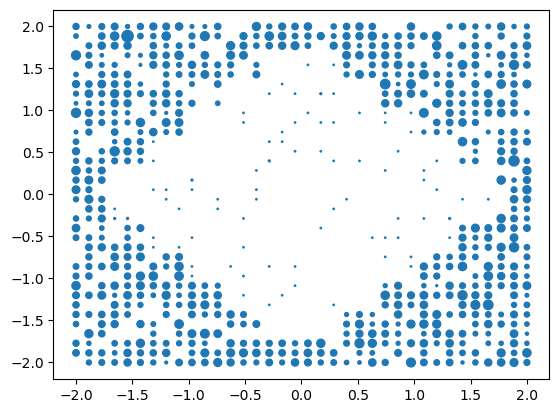

In [9]:
plt.scatter(Xtr[:,0], Xtr[:,1], s=D['Y'][:, 0], )

In [10]:
nmf_model = NMF(n_components=4, max_iter=1000, init='nndsvd', random_state=0, alpha_H=2e-1, alpha_W=1e-7)

In [11]:
nmf_model.fit(D['Y'])

/engelhardt/home/pshrestha/anaconda3/envs/vnngp2/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


NMF(alpha_H=0.2, alpha_W=1e-07, init='nndsvd', max_iter=1000, n_components=4,
    random_state=0)

In [12]:
factors = nmf_model.transform(D['Y'])
loadings = nmf_model.components_.T

In [13]:
print(factors.shape)
print(loadings.shape)

(1037, 4)
(80, 4)


In [14]:
nmf_save_path = path.join(spath, 'nmf/')
factors_path = path.join(nmf_save_path, 'nmf_factors_iter=1000_rs=256_L=4.npy')
loadings_path = path.join(nmf_save_path, 'nmf_loadings_iter=1000_rs=256_L=4.npy')
np.save(factors_path, factors)
np.save(loadings_path, loadings)

In [15]:
moran_idx, moranI = dims_autocorr(factors, D['X'])

In [16]:
X = torch.tensor(Xtr).type(torch.float)
Y = torch.tensor(D['Y'].T).type(torch.float)

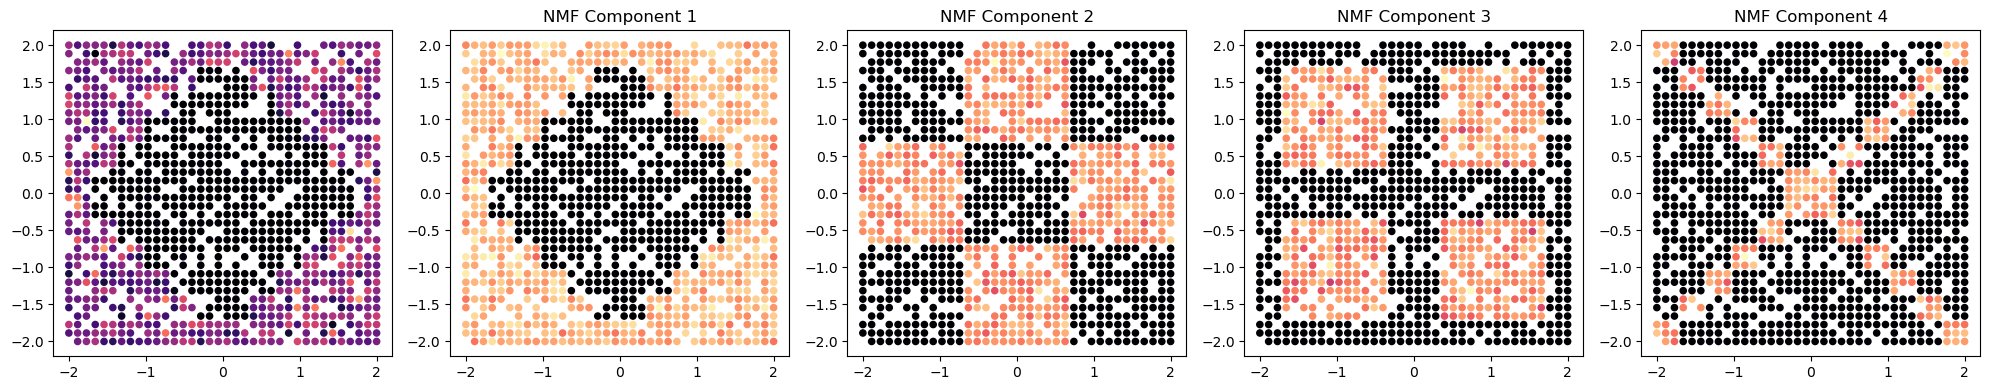

In [17]:
# Create subplots
fig, axes = plt.subplots(1, 4 + 1, figsize=(20, 4))

# Plot original data
axes[0].scatter(X[:, 0], X[:, 1], c=(Y.T)[:,9], cmap='magma', s=20)
#axes[0].set_title('Original')
#axes[0].set_xlabel('Feature 1')
#axes[0].set_ylabel('Feature 2')

# Plot each NMF component
for i in range(4):
    axes[i + 1].scatter(X[:, 0], X[:, 1], c=factors[:, i], cmap='magma', s=20)
    axes[i + 1].set_title(f'NMF Component {i + 1}')

plt.tight_layout()
plt.show()

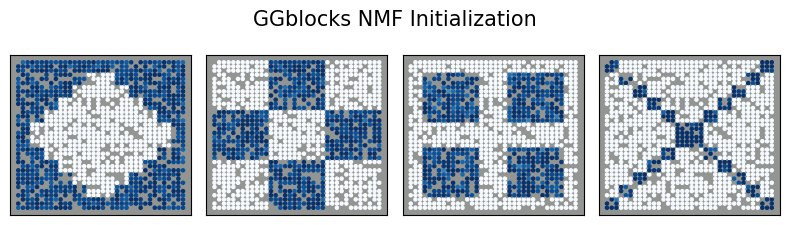

In [18]:
fig = plot_factors(factors.T, X, moran_idx=None, ax=None, size=2, s=5, alpha=1)
fig.suptitle("GGblocks NMF Initialization", size=15)
fig.set_figheight(2.25)
fig.tight_layout()
fig.savefig(path.join(nmf_save_path, 'synthetic_nmf_initialization.png'))

In [19]:
X = torch.tensor(X, dtype=torch.float)
Y = torch.tensor(Y, dtype=torch.float)

/tmp/ipykernel_1001077/4251362955.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float)
/tmp/ipykernel_1001077/4251362955.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y = torch.tensor(Y, dtype=torch.float)


In [20]:
# Normalize the data
#scaler_X = StandardScaler()
scaler_Y = StandardScaler()

#X_scale = scaler_X.fit_transform(X)
Y_scale = scaler_Y.fit_transform(Y)
Y_shifted = Y_scale - Y_scale.min() + 1 # ensure all values are positive

In [24]:
print(X.shape)
print(Y.shape)
print(factors.shape)
print(loadings.shape)

torch.Size([1037, 2])
torch.Size([80, 1037])
(1037, 4)
(80, 4)


In [25]:
X_array = np.array(X.cpu())
Y_array = np.array(Y.cpu())
moran_idx, moranI = putil.dims_autocorr(factors, X_array)
factors=factors[:, moran_idx]
loadings=loadings[:, moran_idx]

In [32]:
X_torch = torch.tensor(X).type(torch.float).to(device)
Y_torch = torch.tensor(Y_shifted).type(torch.float).to(device)

/tmp/ipykernel_1001077/3512649343.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_torch = torch.tensor(X).type(torch.float).to(device)


In [33]:
dicts = {'L': 4, 
          'M': len(X_array), # use total number of inducing points
          'sigma': 0.1, 
          'lengthscale': 0.001, 
          'jtr': 1e-2, 
          'batch_size': 128,
          'lr': 0.0001,
          'rs': 256,
          'lkzz_build': 1,
          'model': 'SVGP',
          'L1_jitter': 1e-1, 
         }

In [36]:
model = putil.build_model_hybrid(np.array(X), np.array(Y_shifted), loadings=loadings, factors=factors, kwargs=dicts)
losses, means, scales, final_time = [], [], [], 0

In [39]:
model.sf.prior.Z.requires_grad=False
model.cf.prior.scale_pf = 1e-1
model.V.requires_grad=False
model.sf.prior.jitter = dicts['jtr']

In [40]:
model.cf.prior.scale.requires_grad = True
model.sf.prior.Lu.requires_grad=True

model.sf.prior.kernel.lengthscale.requires_grad = False
model.sf.prior.kernel.sigma.requires_grad = False
model.sf.prior.mu.requires_grad=False
model.sf.W.requires_grad=False
model.cf.W.requires_grad=False
model.cf.prior.mean.requires_grad=False

In [42]:
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=dicts['lr'])
model.to(device)

Hybrid_NSF2(
  (sf): PoissonFactorization(
    (prior): SVGP(
      (kernel): NSF_RBF()
    )
  )
  (cf): PoissonFactorization(
    (prior): GaussianPrior()
  )
)

In [53]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['TORCH_USE_CUDA_DSA'] = '1'

model.to(device)
more_losses, more_means, more_scales, idxs = putil.train_hybrid_batched(model, optimizer, X_torch, Y_torch.T, device, 
                                                                         steps=100*360, E=3, batch_size=dicts['batch_size'],
                                                                         kwargs=dicts)

  0%|          | 0/36000 [00:00<?, ?it/s]

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [21]:
headers = ['iterations', 'learning_rate', 'sigma', 'lengthscale', 'time', 'rmse_loss']

In [22]:
csv_path = path.join(spath, 'nsfh/synthetic_nsfh_csv_results.csv')

In [23]:
with open(csv_path, 'w', newline='') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(headers)

In [24]:
def run_experiment(X, Y, factors, loadings, save_path, NMF=True, batched=True):
    # Define the parameter grid
    param_grid = {
        'sigma': [0.1],
        'lengthscale': [0.001],
        'learning_rate': [1e-3],
        'iterations': [2000],
    }
    
   
    nsf_path = path.join(spath, 'nsfh/')
                
    with open(csv_path, mode='a', newline='') as file:
        writer = csv.writer(file)
    
        # Iterate over each parameter combination
        for params in ParameterGrid(param_grid):
            dicts = {
                    'L': 4, 
                    'M': len(X), # use total number of inducing points
                    'sigma': params['sigma'], 
                    'lengthscale': params['lengthscale'], 
                    'jtr': 1e-1, # no lower
                    'batch_size': 128,
                    'lr': params['learning_rate'],
                    'rs': 256,
                    'lkzz_build': 1,
                    'model': 'SVGP',
                    'L1_jitter': 1e-1, # no lower
                    'iterations': params['iterations']
                }
    
            kwargs = dicts
    
            file_path = kwargs['model']
            if kwargs['model'] == 'VNNGP':
                file_path += f"_K={kwargs['K']}"
                if kwargs['lkzz_build']:
                    file_path += f"_lkzz={kwargs['lkzz_build']}"
            file_path += f"_M={kwargs['M']}_L={kwargs['L']}_lr={kwargs['lr']}_jtr={kwargs['jtr']}_ls={kwargs['lengthscale']}_sigma={kwargs['sigma']}"

            X_array = None
            Y_array = None
            
            if batched:
                file_path += f"_bs={kwargs['batch_size']}"
            
            if NMF:
                file_path += f"_NMFinit"
                X_array = np.array(X)
                Y_array = np.array(Y)
                moran_idx, moranI = putil.dims_autocorr(factors, X_array)
                factors = factors[:, moran_idx]
                loadings = loadings[:, moran_idx]

            # check of model and its state dictionary already exist
            model_state_path = f'{save_path}/{file_path}_state_dict.pth'
            model_info_path = f'{save_path}/{file_path}_model.pt'

            if path.exists(model_state_path) and path.exists(model_info_path):
                print(f"Loading existing model from {model_state_path} and continuing training.")
                model = putil.build_model_hybrid(X_array, Y_array, loadings=loadings, factors=factors, kwargs=kwargs)
                model.load_state_dict(torch.load(model_state_path))
                
                saved_info = torch.load(model_info_path)
                losses = saved_info.get('losses', [])
                means = saved_info.get('means', [])
                scales = saved_info.get('scales', [])
                final_time = saved_info.get('time', 0)
            else:
                print(f"Training a new model and saving to {model_state_path}.")
                model = putil.build_model_hybrid(X_array, Y_array, loadings=loadings, factors=factors, kwargs=kwargs)
                losses, means, scales, final_time = [], [], [], 0
    
            putil.model_grads_hybrid(model)
            model.sf.prior.jitter = kwargs['jtr']
            optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=kwargs['lr'])
            model.to(device)
            X_torch = torch.tensor(X).type(torch.float).to(device)
            Y_torch = torch.tensor(Y).type(torch.float).to(device)
    
            start_time = time.time()
            more_losses, more_means, more_scales = putil.train_hybrid(model, optimizer, X_torch, Y_torch, device, 
                                                                         steps=kwargs['iterations'], E=3,
                                                                         kwargs=kwargs)
            end_time = time.time()
            final_time += (end_time - start_time)

            # combine new and previous losses, means, scales
            losses.extend(more_losses)
            means.extend(more_means)
            scales.extend(more_scales)

            torch.save(model.state_dict(), model_state_path)
            torch.save({
                'losses': losses,
                'means': means,
                'scales': scales,
                'time': final_time
            }, model_info_path)
    
            with torch.no_grad():
                val_loss = putil.evaluate_model_hybrid(model, X, Y, device)
            
            mean_cv_loss = np.mean(val_loss)
            print(f'Params: {params}, Mean CV Loss: {mean_cv_loss}')
    
            #write the results to the CSV file
            writer.writerow([params['iterations'], params['learning_rate'], params['sigma'], params['lengthscale'], final_time, mean_cv_loss])
    
            fig1, ax1 = plt.subplots()
            ax1.plot(losses)
            fig1.suptitle(f"{kwargs['model']} Loss | sigma: {params['sigma']}, lengthscale: {params['lengthscale']}")
            fig1.savefig(f'{save_path}/{file_path}_loss.png')
            plt.show()
            plt.close()
    
            model.cpu()
            qF, _, _ = model.sf.prior(X.cpu(), kwargs=kwargs)
            mean = torch.exp(qF.mean).detach().numpy()
            
            fig2 = plot_factors(mean, X.cpu().detach().numpy(), moran_idx=moran_idx, size=2, s=5, alpha=1, ax=None)
            fig2.suptitle("GGblocks NSF", size=15)
            fig2.set_figheight(2.25)
            fig2.tight_layout()
            fig2.savefig(f'{save_path}/{file_path}_plot.png')
            plt.show()
            plt.close()
            model.to(device)

In [25]:
save_path = path.join(spath , 'nsfh')
run_experiment(X, Y, factors, loadings, save_path)

Training a new model and saving to /engelhardt/home/pshrestha/vnngp/results/synthetic/nsfh/SVGP_M=1037_L=4_lr=0.001_jtr=0.1_ls=0.001_sigma=0.1_bs=128_NMFinit_state_dict.pth.


AttributeError: module 'gpzoo.pri_experiment_utilities' has no attribute 'model_grads_hybrid'